<a href="https://colab.research.google.com/github/vgarcialopezm/ABC-SMC/blob/main/seq_MC_10particulas_datos_reales_ESTESI%CC%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [150]:

import numpy as np
from scipy.stats import norm, uniform, multivariate_normal
from scipy.optimize import minimize
from scipy.special import logsumexp
import sys,ast
from math import exp,log
from random import choices,seed,random
from tqdm import tqdm
#import p_tqdm
from functools import partial
import os
import matplotlib.pyplot as plt


epsilons=[3000.0,2000.0,1000.0,500.0,300.0,200.0,100.0,50.0,20.0,10.0,5.0]
#epsilons=[16.0,12.0,11.8,11.3,10.6,7.1,5.2]

parametros=[1,1]#1,1]
print(type(parametros))

params_tumor = [ # list of parameters used in the lotka volterra model 
    {'name' : 'Dn', 'lower_limit':0.0,'upper_limit':0.5},# growing rate of prey in absence of repressor
    {'name' : 'Dc','lower_limit':50.0,'upper_limit':70.0},#susceptibility of prey 
    {'name' : 'am','lower_limit':8000.0,'upper_limit':9000.0},# extinction rate of predator
  #  {'name' : 'd','lower_limit':0.0,'upper_limit':2.0}# benefit of predator
]

<class 'list'>


In [3]:
handler=open('doblaredia3.txt')

In [4]:
datos=handler.read()
print(datos)

24.163   
27.358
31.633
34.039
38.274
39.835
39.934
39.934
39.934
39.93 
38.204
35.829
35.525
38.566
41.504
45.336
48.705
48.323
47.075
46.095
45.96 
45.572
45.572
44.509
42.632
41.07 
42.676
47.939
51.679
56.57 
59.239
56.762
53.897
48.094
48.937
50.442
52.776
51.723
52.528
51.906
53.35 
56.461
58.991
62.004
62.772
61.928
59.891
55.457
51.743
51.684
53.494
57.034
58.348
53.571
53.199
55.779
53.923
51.947
52.075
53.672
55.238
55.238
55.635
55.609
53.82 
51.8
51.759
53.189
54.875
57.224
59.054
58.528
54.97 
52.806
51.211
51.211
51.575
53.309
51.622
50.17 
49.054
48.3
48.794
48.794
48.37 
47.989
48.489
49.332
49.6
50.827
51.862
52.705
52.822
52.822
51.216
51.211
51.356
52.822
52.97 
53.441
53.046
54.152
55.538
56.044
56.795
57.654
57.654
57.654
57.127
56.284
56.044
56.044
54.686
53.
52.822
49.653
47.989
48.114
49.92 
52.702
55.766
57.654
57.403
57.138
56.673
55.238
55.641
56.484
56.37 
55.527
54.684
53.84 
56.567
61.616
64.604
64.16 
61.754
60.05 
58.785
57.833
59.266
59.761
63.712
68.89

In [5]:
datos = np.loadtxt('doblaredia3.txt', delimiter=',')


In [6]:
datosdia6=np.loadtxt('datosdia6.txt', delimiter=',')


In [167]:
taup=4800
beta1=2.5
a3H0=0.0085
d1=0.2
a0=0.45185
a1=0.51
a2=1
d2=0.1
e2f=1
am=8250
beta=0.5
#value of p6/p3 set to 1
p6p3=1
#c critico
# Calculate the value of c_cr using the parameters above and the expression given in the document
ccr=1-1/beta1*np.log(1/a3H0*(a1+(a2*d2/d1*e2f)*(1-1/(1-a0))))
#Calculate a(G1/S) using the parameter values above
# aG1S=am*(c/ccr-1)**(-beta)
#aG1S=2e+04
nu=4.16667e-06

#Let's apply Newton Raphson method in order to obtain the values of lambda given in the document (it will be named lam)
x0=0
max_iter=20
tolerance=0.000000000001

# #Expression of the function to obtain the value of lambda
# f=lambda lam:taup/2-(exp(-(lam+nu)*aG1S)/(lam+nu+1/taup))
  
# #Fist derivative of th previos function 
# Df=lambda lam:(exp(-(lam+nu)*aG1S)*(-aG1S*(lam+nu+1/taup)-1))/(lam+nu+1/taup)**2



In [168]:
def newton_raps(c,am):
    #print('c',c)
    aG1S=am*(c/ccr-1)**(-beta)
    #print(aG1S)
    #print('ag1s',aG1S)
    #Expression of the function to obtain the value of lambda
    f=lambda lam:log(taup)-log(2)+lam*aG1S+nu*aG1S+log(lam+nu+1/taup)
  
    #Fist derivative of th previos function 
    Df=lambda lam: aG1S+1/(lam+nu+1/taup)
    #tabla = []
    section = abs(2*tolerance)
    xi = x0
    while (section>=tolerance):
        xnew = xi - f(xi)/Df(xi)
        section  = abs(xnew-xi)
        #tabla.append([xi,xnew,section])
        xi = xnew
    return xi
#xi=newton_raps(c)


In [177]:
#spatial grid
J=916
L=191
dx=0.482
#x_grid = np.array([l*dx for l in range(J)])
x_grid=np.linspace(0,J,L)
#L=np.size(x_grid)
#time grid
T=3  #final time (NUMBER OF MINUTES IN 3 DAYS)
N=300 #NUMBER OF TIME STEPS
dt=T/N #T/N  #time step
#t_grid = np.array([t*dt for t in range(N)])
t_grid=np.linspace(0,T,N)
#n=np.array(100 for k in range(L))
#System parameters
delta=dx**2/dt
Dn=60e-03 #*delta
Dc=60 #*delta
sigma_u=Dn*dt/(dx**2)
sigma_v=Dc*dt/(dx**2)
k1= 9.42e-04 #/dt
k2=9.42e-02 #/dt
#c=0.1
betaf=1 #40.012

In [169]:

x_grid

array([  0.        ,   4.82105263,   9.64210526,  14.46315789,
        19.28421053,  24.10526316,  28.92631579,  33.74736842,
        38.56842105,  43.38947368,  48.21052632,  53.03157895,
        57.85263158,  62.67368421,  67.49473684,  72.31578947,
        77.13684211,  81.95789474,  86.77894737,  91.6       ,
        96.42105263, 101.24210526, 106.06315789, 110.88421053,
       115.70526316, 120.52631579, 125.34736842, 130.16842105,
       134.98947368, 139.81052632, 144.63157895, 149.45263158,
       154.27368421, 159.09473684, 163.91578947, 168.73684211,
       173.55789474, 178.37894737, 183.2       , 188.02105263,
       192.84210526, 197.66315789, 202.48421053, 207.30526316,
       212.12631579, 216.94736842, 221.76842105, 226.58947368,
       231.41052632, 236.23157895, 241.05263158, 245.87368421,
       250.69473684, 255.51578947, 260.33684211, 265.15789474,
       269.97894737, 274.8       , 279.62105263, 284.44210526,
       289.26315789, 294.08421053, 298.90526316, 303.72

[24.163 27.358 31.633 34.039 38.274 39.835 39.934 39.934 39.934 39.93
 38.204 35.829 35.525 38.566 41.504 45.336 48.705 48.323 47.075 46.095
 45.96  45.572 45.572 44.509 42.632 41.07  42.676 47.939 51.679 56.57
 59.239 56.762 53.897 48.094 48.937 50.442 52.776 51.723 52.528 51.906
 53.35  56.461 58.991 62.004 62.772 61.928 59.891 55.457 51.743 51.684
 53.494 57.034 58.348 53.571 53.199 55.779 53.923 51.947 52.075 53.672
 55.238 55.238 55.635 55.609 53.82  51.8   51.759 53.189 54.875 57.224
 59.054 58.528 54.97  52.806 51.211 51.211 51.575 53.309 51.622 50.17
 49.054 48.3   48.794 48.794 48.37  47.989 48.489 49.332 49.6   50.827
 51.862 52.705 52.822 52.822 51.216 51.211 51.356 52.822 52.97  53.441
 53.046 54.152 55.538 56.044 56.795 57.654 57.654 57.654 57.127 56.284
 56.044 56.044 54.686 53.    52.822 49.653 47.989 48.114 49.92  52.702
 55.766 57.654 57.403 57.138 56.673 55.238 55.641 56.484 56.37  55.527
 54.684 53.84  56.567 61.616 64.604 64.16  61.754 60.05  58.785 57.833
 59.266 5

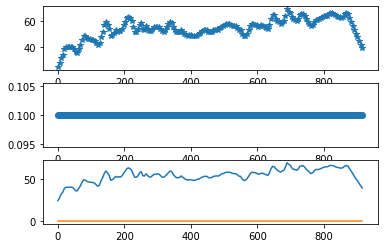

In [154]:
#Initial value for population
#U = np.array([100 for i in range(0,L)])
U = datos #np.array([100 for i in range (0,L)])
#U = np.array([4259.0 for i in range(0,L)]) #lo que ha puedto pilar
print(U)

#Initial value for oxygen concentration
#V = np.array([0.1 for i in range (0,L)])
V = np.array([0.1 for i in range(0,L)])
#V = np.array([10 for i in range(0,L)])  #lo que ha puesto pilar
print(V)

#graphic of the initial population and oxygen concentration
fig,axs = plt.subplots(3)
axs[0].plot(x_grid,U,'*')
axs[1].plot(x_grid,V,'o')
axs[2].plot(x_grid,U,x_grid,V)
plt.show()
# plt.ylabel('population')
# plt.plot(x_grid, U)
# plt.plot(x_grid, V)
# plt.show()

#pyplot.plot(x_grid, U)
#pyplot.plot(x_grid, V)
#pyplot.show()


In [ ]:
data1=np.array([U,V]).T

In [144]:
fu=lambda lamda_vect, U: np.multiply(lamda_vect,U)

aux=np.zeros(L)
aux[-1]= 4*dx*betaf*sigma_v
#aux[0]= 4*dx*betaf*sigma_v
g=lambda U,V: -k1*U*V-k2*V   #+aux

In [14]:
sigma_u

0.25826001618429434

In [15]:
Dc

60

In [161]:
def crank_nic(fu,g,aux,Dn,Dc,am,U,V,L):
    sigma_u=Dn*dt/(dx**2)
    sigma_v=Dc*dt/(dx**2)
    #Matrices for Crank Nicholson in equation of population of cells
    A_n = np.diagflat([-sigma_u for i in range(L-2)]+[-2*sigma_u], -1) +\
      np.diagflat([2.+2.*sigma_u for i in range(L)]) +\
      np.diagflat([-2.*sigma_u]+[-sigma_u for i in range(L-2)], 1)
    
    B_n = np.diagflat([sigma_u for i in range(L-2)]+[2.*sigma_u], -1) +\
      np.diagflat([2.-2.*sigma_u for i in range(L)]) +\
      np.diagflat([2.*sigma_u]+[sigma_u for i in range(L-2)], 1)
    #Matrices for Crank Nicholson in equation of oxygen
    A_c = np.diagflat([-sigma_v for i in range(L-2)]+[-2*sigma_v], -1) +\
      np.diagflat([2.+2.*sigma_v for i in range(L)]) +\
      np.diagflat([-2.*sigma_v]+[-sigma_v for i in range(L-2)], 1)
    
    B_c = np.diagflat([sigma_v for i in range(L-2)]+[2.*sigma_v], -1) +\
      np.diagflat([2.-2.*sigma_v for i in range(L)]) +\
      np.diagflat([2.*sigma_v]+[sigma_v for i in range(L-2)], 1)
    
    lamda_vect=np.zeros(L)
    for i in range(L):
        xi=newton_raps(V[i],am)
        lamda_vect[i]=xi #np.longfloat(xi)
    
    for ti in range(1,N):
        #print('step',ti)
        U_new = np.linalg.solve(A_n, (B_n.dot(U) + 2*dt*(lamda_vect*U)))
        V_new = np.linalg.solve(A_c, (B_c.dot(V) +2*dt*g(U,V)+aux))
        lamda_vect=np.zeros(L)
        V = V_new
        for i in range(L):
            xi=newton_raps(V[i],am)
            lamda_vect[i]=np.longfloat(xi)
        #print(lamda_vect)
        U = U_new
    #print(U_new)
    #print(V_new)
    return U,V 




In [178]:
data1_c=crank_nic(fu,g,aux,Dn,Dc,am,U,V,L)
data1_c=np.array(data1_c).T
data1_c

array([[2.72176839e+01, 9.53764222e-02],
       [2.84879221e+01, 9.56155268e-02],
       [3.12771598e+01, 9.63367574e-02],
       [3.43027463e+01, 9.75515621e-02],
       [3.70858532e+01, 9.92786207e-02],
       [3.88745324e+01, 1.01543904e-01],
       [3.96345030e+01, 1.04380707e-01],
       [3.98268246e+01, 1.07830007e-01],
       [3.97022488e+01, 1.11941091e-01],
       [3.91558796e+01, 1.16772212e-01],
       [3.80598245e+01, 1.22391197e-01],
       [3.70635219e+01, 1.28876141e-01],
       [3.72777455e+01, 1.36316556e-01],
       [3.90946613e+01, 1.44814919e-01],
       [4.18350876e+01, 1.54488123e-01],
       [4.47639282e+01, 1.65468549e-01],
       [4.69029825e+01, 1.77905206e-01],
       [4.75125078e+01, 1.91964771e-01],
       [4.70900973e+01, 2.07832795e-01],
       [4.64481849e+01, 2.25715816e-01],
       [4.59827423e+01, 2.45844001e-01],
       [4.55923629e+01, 2.68473822e-01],
       [4.50751708e+01, 2.93890597e-01],
       [4.41742311e+01, 3.22411169e-01],
       [4.315295

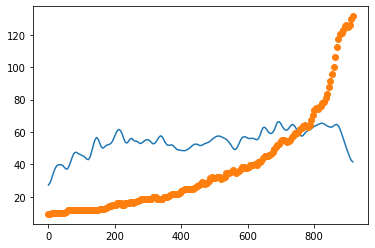

In [179]:
plt.figure()
plt.plot(x_grid,data1_c[:,0])
plt.plot(x_grid,datosdia6,'o')
#plt.plot(x_gridi,data1_c[:,1],'*')
#plt.plot( t, data3,'x')

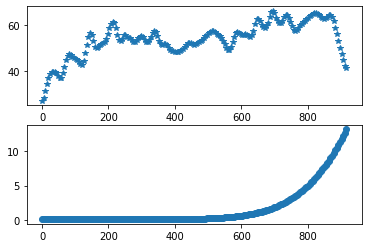

In [98]:
fig,axs = plt.subplots(2)
axs[0].plot(x_grid,data1_c[:,0],'*')
axs[1].plot(x_grid,data1_c[:,1],'o')
plt.show()

In [20]:
def add_noise(mu,sigma,data):
    noise=np.random.normal(mu,sigma)
    data_noise=data+noise
    return data_noise


In [ ]:
data1_noise=(add_noise(0,0.5,data1_c))
print('data1 noise',data1_noise)


data1 noise [[ 47.43044701  17.48030859]
 [ 47.57745477  17.48278757]
 [ 48.00149376  17.49023021]
 [ 48.65556787  17.50265221]
 [ 49.47343864  17.52007731]
 [ 50.38424086  17.54253626]
 [ 51.32700328  17.57006362]
 [ 52.26130891  17.60269617]
 [ 53.17155179  17.64047184]
 [ 54.06411883  17.68342918]
 [ 54.95879391  17.73160771]
 [ 55.87720828  17.7850482 ]
 [ 56.83184789  17.84379362]
 [ 57.81881555  17.90788985]
 [ 58.81634838  17.9773859 ]
 [ 59.78937461  18.05233259]
 [ 60.6986686   18.13278181]
 [ 61.51192673  18.2187852 ]
 [ 62.21365443  18.31039246]
 [ 62.81117012  18.40765137]
 [ 63.3350903   18.51060806]
 [ 63.83402774  18.61930806]
 [ 64.36458671  18.73379772]
 [ 64.97883344  18.85412644]
 [ 65.71209194  18.98034825]
 [ 66.57402788  19.11252316]
 [ 67.54542861  19.25071764]
 [ 68.58185127  19.39500449]
 [ 69.62358903  19.54546153]
 [ 70.60963348  19.70216861]
 [ 71.49206856  19.86520638]
 [ 72.24710459  20.034654  ]
 [ 72.87989444  20.21058775]
 [ 73.42206881  20.39308205]
 [

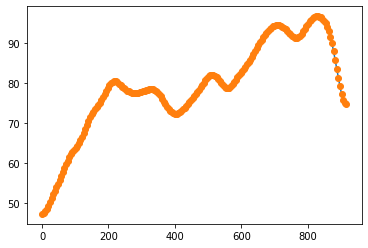

In [ ]:
plt.figure()
plt.plot(x_grid, data1_c[:,0]) #data1_N[:,0])
plt.plot(x_grid,data1_noise[:,0],'o')
#plt.plot(x_gridi,data1_c[:,1],'*')
#plt.plot( t, data3,'x')

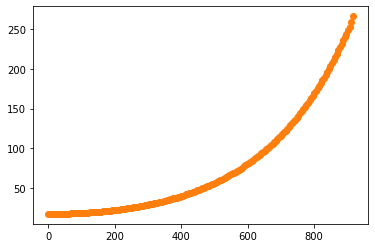

In [ ]:
plt.figure()
plt.plot(x_grid,data1_c[:,1])
plt.plot(x_grid,data1_noise[:,1],'o')
#plt.plot(x_gridi,data1_c[:,1],'*')
#plt.plot( t, data3,'x')

In [21]:
def euc_dist(data1, data2):
    if np.shape(data1) != np.shape(data2):
        print ("\n the dimensions of the datasets are different (%s v.s. %s)\n" % (len(data1), len(data2)))
        sys.exit()
    else:
        distance = np.linalg.norm(data1 - data2)
        print('dist',data1 - data2)

    if distance < 0:
        return [None]
    else:
        return distance


In [44]:

def euc_disti(data1, data2):
    if np.shape(data1) != np.shape(data2):
        print ("\n the dimensions of the datasets are different (%s v.s. %s)\n" % (len(data1), len(data2)))
        sys.exit()
    else:
        z =np.array((data1 - data2)**2)
        #print (z)
        distance=np.sum(z)

    if distance < 0:
        return [None]
    elif np.isnan(distance):
        distance=100000
        return distance
    else:
        return distance



In [ ]:
euc_disti(data1_c,data1_noise)

0.5442485351925432

In [22]:
def prior():
### Generate a random parameter inside the limits stablished. The shape of the distribution can be changed if required
    prior = []
    for ipar,par in enumerate(params_tumor):
        prior.append(uniform.rvs(loc = par['lower_limit'],
                                 scale = par['upper_limit']-par['lower_limit'])) #par['upper_limit']))
        
       
    return prior


In [25]:
#function that given the values of the parameters, calculates the 

def evaluate_prev_pru(params):
    print('parameters',params)
    l=len(params)
    prior = 1
    for ipar,par in enumerate(params_tumor):
    #for i in range(l):
        prior *= uniform.pdf(params[ipar],loc = par['lower_limit'],
                                 scale = par['upper_limit']-par['lower_limit'])
        if prior==0:
            break   
      #  print('params i', params[i])
       # print('prior',prior)
    return prior


In [26]:
#function that, given a list of parameters sampled, perturbs it by applying a multivariate normal kernel
def perturb(listaprev,s):
    #print(listaprev)
    lista=np.asarray(listaprev) #.tolist()
    #mean_vec=np.mean(lista)
    cov_matrix=2.0*np.cov(lista.T)  #the covariance matrix for the multivariate normal perturbation kernel is given by this expression
    kernel=multivariate_normal(cov=cov_matrix)
    pert=s+kernel.rvs() # here we obtain the list of perturbed parameters
    pertur=pert.tolist()
    return pertur


In [27]:



#function that gives the denominator used to calculate the weights of every particle.
def weighting(i,j,N,sam,wei,sampre):
     denom=0
     #ker=1
     samprev=np.asarray(sampre)
     cov_matrix=2.0*np.cov(samprev.T)
     kernel=multivariate_normal(cov=cov_matrix)
     for k in range(N):
            #print('sample i j',type(sam[k]),sam[k])
           # print('sample i-1,j',type(sampre[k]),sampre[k])
            sampre[k]=np.array(sampre[k])
            #print('sampre',sampre[k])
            #cov_matrix=2.0*np.cov((sampre[k]).T)  #the covariance matrix for the multivariate normal perturbation kernel is given by this expression
            #print('cov',cov_matrix)
            #kernel=multivariate_normal(cov=cov_matrix)
            # print('wei',wei[i-1,k])
            #print('sam[j]',sam[j])
            #print('sampre[k]',sampre[k])
            ker=kernel.pdf(sam[j]-sampre[k])
            #print('ker',ker)
            #kerne=np.prod(ker)  #here we are obtaining the joint probability of the parameter vector obtained when applying the kernel
            denom+=wei[k]*ker #kerne
            #print('kernel',kernel.cdf(sam[k]-sampre[k]))
     #print('den',denom)      
     return denom


    


In [28]:
#function used to normalize the weights
def normalize(wei):
    #normalized=wei/np.linalg.norm(wei)
    normalized=wei/np.sum(wei)
    return normalized  



In [40]:
def principal(epsilons,listaparametros,N,data1):
   # accepted_distances = np.loadtxt('smc/distances_{}_{}_{}_{}.out'.format(model,sto,gamma,prior_label))
    T=len(epsilons)
    weight=np.zeros((T,N),float)
    dist=np.zeros((T,N),float)
    sample=np.zeros((T,N),list)
    #X0=[Ui,Vi]
    #t=np.linspace(0.,10,10)
    for i in range(T):
        count=0
        counti=0
        label=i
        print("SMC step with target distance: {}".format(epsilons[i]))
        if i==0:
            for j in range (N):
                dist[i,j]=epsilons[i]+1
                while dist[i,j]>epsilons[i]:
                    sample[i,j]=prior()
                    #sample[i,j]=np.array(prior())
                    sample[i,j]=np.asarray(sample[i,j])
                    print(sample[i,j][0])
                    print(sample[i,j][1])
                    print(sample[i,j][2])
                    data2= np.array(crank_nic(fu,g,aux,sample[i,j][0],sample[i,j][1],sample[i,j][2],U,V,L)).T
                    print('data2',data2)
                    print('data1',data1)
                    #print('data2',data2)
                    #data2=np.array(data2, dtype=np.float64)
                    dist[i,j]=euc_disti(data1,data2)
                    print('distcondata2',dist[i,j])
                count+=1
                print(count)
       
        else:
        
            for j in range (N):
                dist[i,j]=epsilons[i]+1
                while dist[i,j]>epsilons[i]:
                    seed()
                    np.random.seed()
                    choose = choices(sample[i-1,:], weights = weight[i-1,:],k=1)[0] # select a point from the previous sample
                    sample[i,j]=choose
                    print("before perturb",type(sample[i,j]))
                    print("before perturb",list(sample[i-1,:]))
                    sample[i,j] = perturb(list(sample[i-1,:]),sample[i,j]) # and perturb it
                    #print("after perturb", sample[i,j])
                    #print("after perturb", type(sample[i,j]))
                    evaluation=evaluate_prev_pru(sample[i,j]) 
                    if evaluation>0:
                        data2=np.array(crank_nic(fu,g,aux,sample[i,j][0],sample[i,j][1],sample[i,j][2],U,V,L)).T
                        data2=np.array(data2)
                        #print('data2',data2)
                        dist[i,j]=euc_disti(data1,data2)
                        print('distendata2',dist[i,j])
                counti+=1
                print(counti)
        for j in range(N):
            if i==0:
                weight[i,j]=1
               # print(weight[i,j])
            else:
                denom=weighting(i,j,N,sample[i,:],weight[i-1,:],list(sample[i-1,:]))
                weight[i,j]=evaluate_prev_pru(sample[i,j])/denom
        #print('weight[i,:]',weight[i,:])
        if i!=0:
           weight[i,:]=normalize(weight[i,:])
           #print('weight[i,:] normalized',weight[i,:])
        #pars = np.loadtxt('smc_van/pars_{}.out'.format(i))
        #weights = np.loadtxt('smc_van/weights_{}.out'.format(i))
        #np.savetxt('smc_van/pars_{}.out'.format(i), sample[T-1,:])
        #np.savetxt('smc_van/weights_{}.out'.format(i), weight[T-1,:])
      #  np.savetxt('smc/distances_{}.out'.format(label), accepted_distances)
    #print('sample',sample[T-1,N-1])
    #print('weight',weight[T-1])
    #print('dist',dist[T-1])
    return sample, weight, dist,data2


In [111]:
sample,weight,dist,data2=principal(epsilons,params_tumor,20,data1_c)

Se han truncado las últimas 5000 líneas del flujo de salida.
 [6.34342499e+01 5.00637269e+00]
 [6.39604716e+01 5.23264213e+00]
 [6.43947243e+01 5.46728894e+00]
 [6.49126153e+01 5.71054053e+00]
 [6.53296413e+01 5.96262971e+00]
 [6.53673455e+01 6.22379090e+00]
 [6.49939987e+01 6.49425365e+00]
 [6.43763590e+01 6.77424078e+00]
 [6.37536242e+01 7.06397127e+00]
 [6.32843540e+01 7.36366561e+00]
 [6.29756296e+01 7.67354997e+00]
 [6.30512425e+01 7.99385686e+00]
 [6.36367106e+01 8.32483216e+00]
 [6.44292741e+01 8.66674042e+00]
 [6.46875622e+01 9.01985729e+00]
 [6.38245835e+01 9.38444606e+00]
 [6.17926877e+01 9.76073560e+00]
 [5.90890605e+01 1.01489141e+01]
 [5.60783994e+01 1.05491427e+01]
 [5.30202620e+01 1.09615656e+01]
 [5.01439357e+01 1.13863195e+01]
 [4.74352049e+01 1.18235419e+01]
 [4.47657204e+01 1.22733713e+01]
 [4.25077134e+01 1.27359408e+01]
 [4.15066704e+01 1.32113973e+01]]
distcondata2 32.64911666582082
15
0.07711161860962179
54.127580293288204
8080.499614648244
data2 [[2.77188126e+01

In [112]:

print("min accepted distance: ",np.min(dist[-1,:]))
print("median accepted distance: ",np.median(dist[-1,:]))
#print("median evaluated distance: ",np.median(evaluated_distances))


min accepted distance:  0.19826615598381125
median accepted distance:  3.22883043635151


In [ ]:
np.median(sample[-1,:])

array([6.35874784e-02, 3.12714315e+01, 4.34836302e+03, 7.85644300e-02,
       3.03626078e+01, 4.59721256e+03])

In [ ]:
parama=[]
for j in sample[-1,:]:
    parama.append(j[0])
    


In [ ]:
amean=np.mean(parama)
amed=np.median(parama)
print('mean',amean)
print('median',amed)

mean 0.15058190656427436
median 0.14215190841638425


In [ ]:
paramb=[]
for j in sample[-1,:]:
    paramb.append(j[1])
    


In [ ]:
bmean=np.mean(paramb)
bmed=np.median(paramb)
print('mean',bmean)
print('median',bmed)

mean 61.071154249611574
median 60.78556408376129


In [ ]:
np.shape(data1_noise)

(191, 2)

In [ ]:
np.shape(data2)

(191, 2)

In [ ]:
sample[-1,:][0]

[0.24621379827656992, 60.2906335982911, 9374.602460612028]

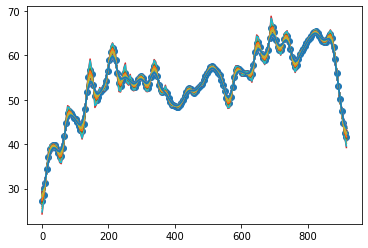

In [101]:

plt.figure()
plt.plot(x_grid,data1_c[:,0],'o')
for i in sample[-1,:]:
    data2=np.array(crank_nic(fu,g,aux,i[0],i[1],i[2],U,V,L)).T
    plt.plot(x_grid,data2[:,0])
plt.show()

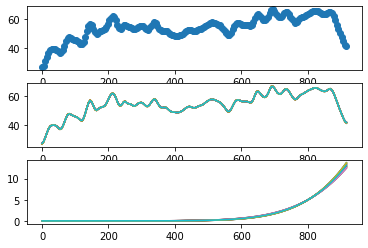

In [114]:
fig,axs = plt.subplots(3)

axs[0].plot(x_grid,data1_c[:,0],'o')
for i in sample[-1,:]:
    data2=np.array(crank_nic(fu,g,aux,i[0],i[1],i[2],U,V,L)).T
    axs[1].plot(x_grid,data2[:,0])
    axs[2].plot(x_grid,data2[:,1])
plt.show()

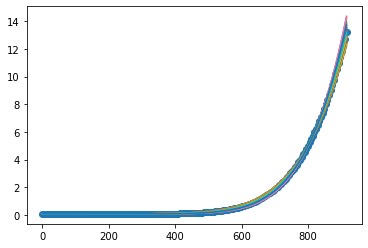

In [103]:
plt.figure()
plt.plot(x_grid,data1_c[:,1],'o')
for i in sample[-1,:]:
    data2=np.array(crank_nic(fu,g,aux,i[0],i[1],i[2],U,V,L)).T
    plt.plot(x_grid,data2[:,1])
plt.show()

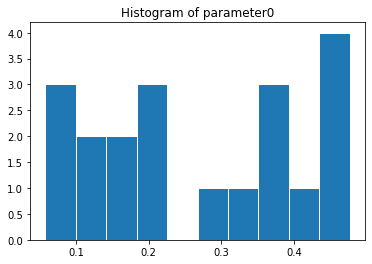

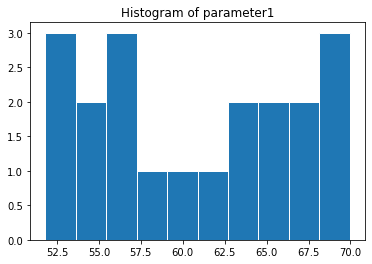

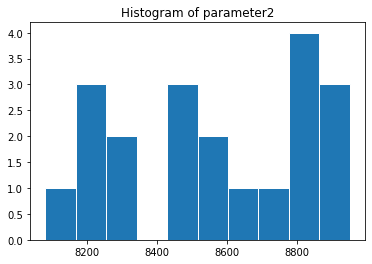

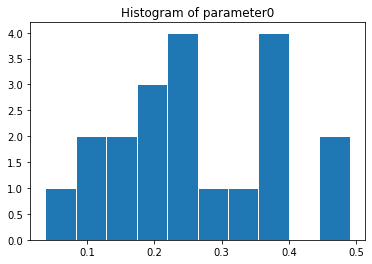

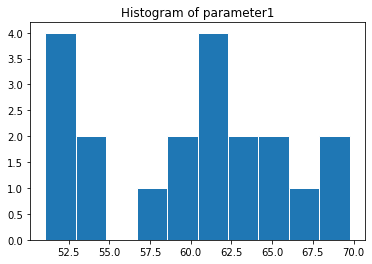

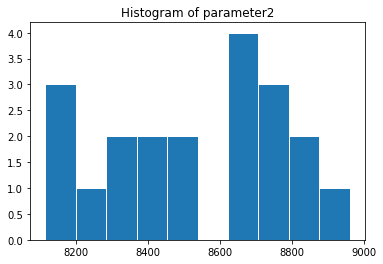

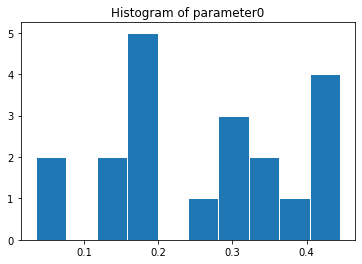

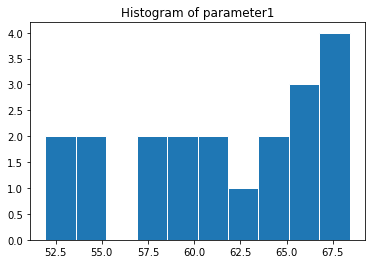

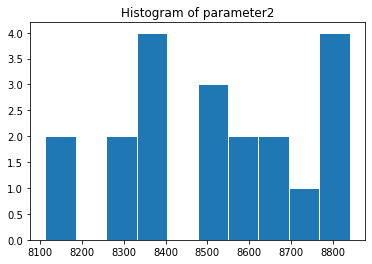

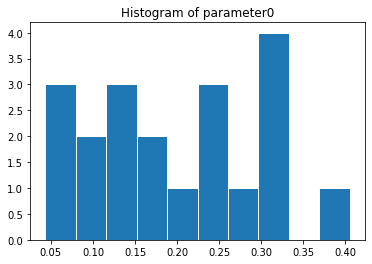

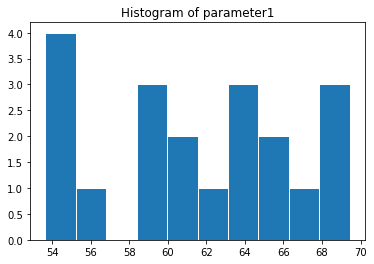

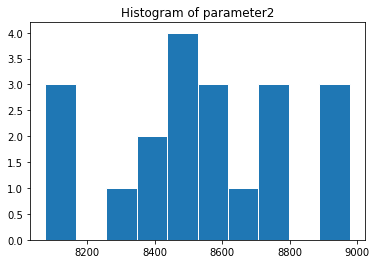

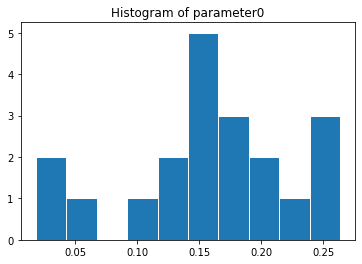

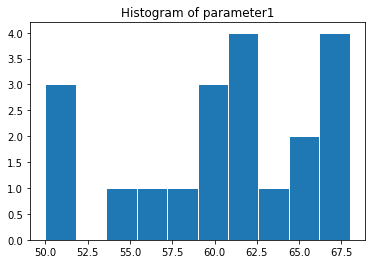

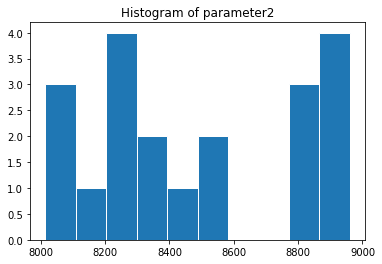

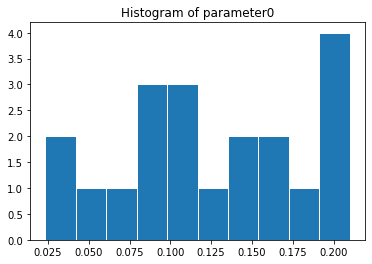

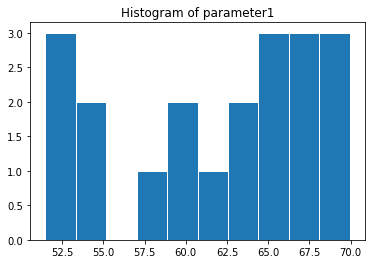

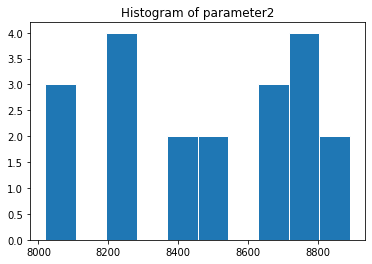

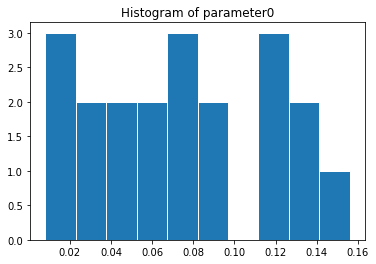

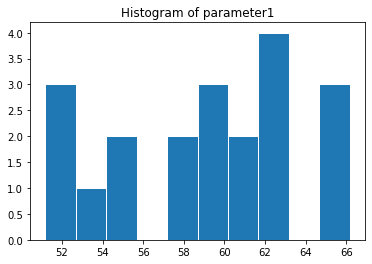

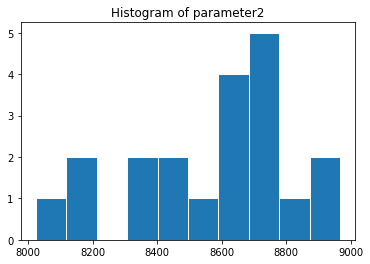

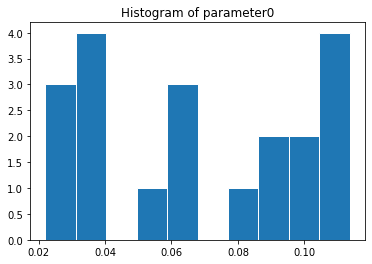

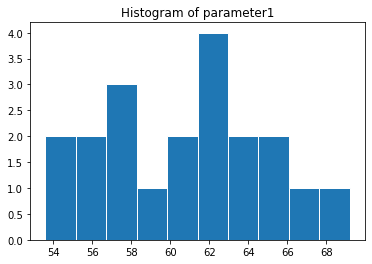

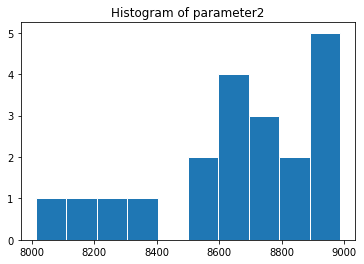

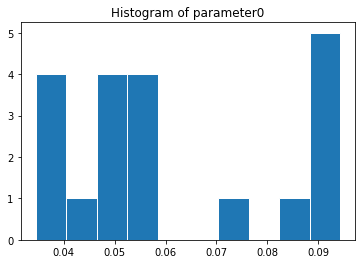

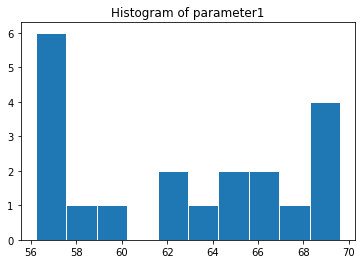

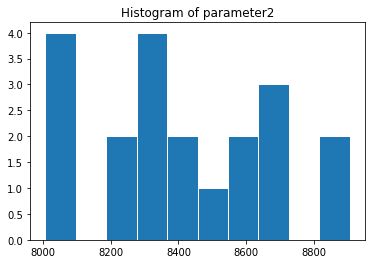

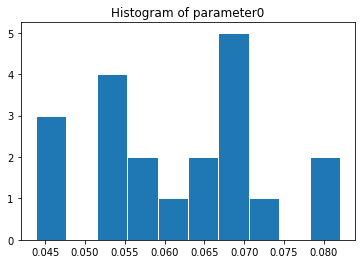

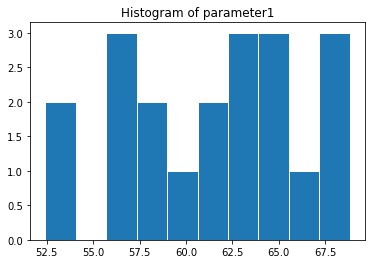

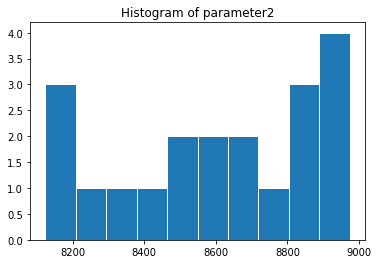

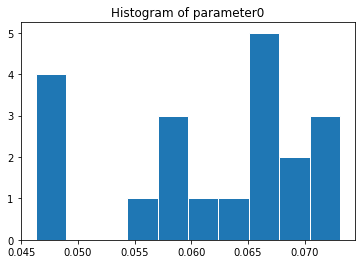

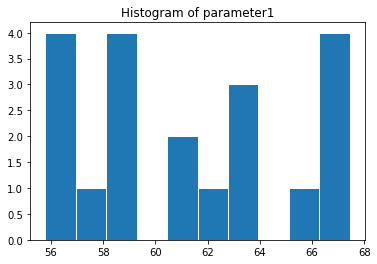

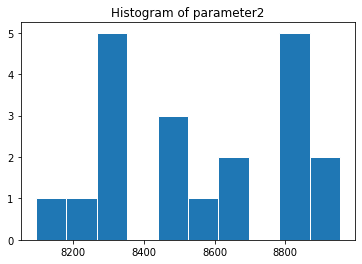

In [115]:
for k in range(len(epsilons)):
    for j in range(len(params_tumor)):
        plt.figure()
        b=[]
        for i in sample[k,:]:
            b.append(i[j])
        al=np.histogram(b)
        n,bins,patches=plt.hist(b,edgecolor='white')
        plt.title('Histogram of parameter'+str(j))
    plt.show()
plt.show()


In [105]:
mindis=np.min(dist[-1,:])
mindis

1.6646964580233137

In [ ]:
maxdis=np.max(dist)
np.where(dist==mindis)

(array([3]), array([3]))

In [ ]:
maxdis

4281.408060591355

In [ ]:
dist[-1,:]

array([916.92878413, 856.83028974, 657.76463212,  82.15938924,
       195.01326563, 689.78866771, 917.79277168, 706.69752922,
       462.56973763, 720.16895596])

In [ ]:
dati=np.array(crank_nic(fu,g,aux,sample[3,3][0],sample[3,3][1],sample[3,3][2],U,V,L)).T

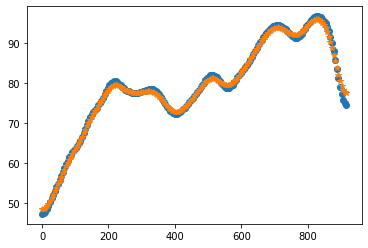

In [ ]:
plt.figure()
plt.plot(x_grid,data1_c[:,0],'o')
plt.plot(x_grid,dati[:,0],'*')
plt.show()

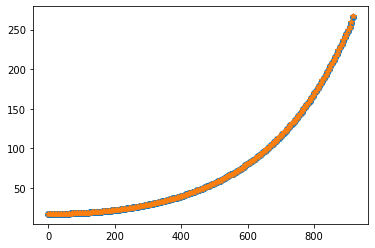

In [ ]:
plt.figure()
plt.plot(x_grid,data1_c[:,1],'o')
plt.plot(x_grid,dati[:,1],'*')
plt.show()